In [1]:
import deepdish as dd
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import deepdish as dd
import argparse
import numpy as np
import javabridge as jv
import bioformats as bf
from pyprind import prog_percent
from xml import etree as et
from queue import Queue
from threading import Thread, Lock
from enum import Enum
import torch as th
from torch.autograd import Variable
from torch.nn.functional import grid_sample
from tqdm import tqdm_notebook
import h5py
import os
from skimage.feature import blob_log
from skimage.draw import circle
from skimage.transform import AffineTransform, warp
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.cm as mplColorMap
import ipywidgets as widgets
#import ipyvolume as ipv
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import deepdish as dd
from skimage.external.tifffile import imsave
from skimage.feature import register_translation
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import AffineTransform, warp
from pyprind import prog_bar
import time
import matplotlib.pyplot as plt

In [17]:
class Pyfish:

    def __init__(self, file_id, save_path="", align_to_frame=0, use_gpu=True, max_displacement=300, thread_count=4):
        #self.lif_file_path = lif_file_path
        self.file_id=file_id
        self.align_to_frame = align_to_frame #un frami ke nesbat be un baghie axaro align mikonim
        self.use_gpu = use_gpu
        self.max_displacement = max_displacement
        self.thread_count = thread_count

        self._start_lif_reader()
        print('Number of timepoints: ',self.n_timepoints)
        self.frame_shape=(self.n_timepoints, 1024, 1024)
        #self.frame_shape=


    # start lif reader
    # set image stack shape
    # lif files can contain multiple stacks so we pick the index of one with more than one frames in lif_stack_idx
    def _start_lif_reader(self):
        jv.start_vm(class_path=bf.JARS)

        log_level = 'ERROR'
        
        if self.file_id[1]=='control':
        
            file_path='//ZMN-HIVE/User-Data/Maria/control/fish'+self.file_id[0]+'_6dpf_medium.lif'
        elif self.file_id[1]=='amph':
            file_path='//ZMN-HIVE/User-Data/Maria/stimulus/fish'+self.file_id[0]+'_6dpf_amph.lif'
        

        self.ir = bf.ImageReader(file_path, perform_init=True)

        mdroot = et.ElementTree.fromstring(bf.get_omexml_metadata(file_path))
        mds = list(map(lambda e: e.attrib, mdroot.iter('{http://www.openmicroscopy.org/Schemas/OME/2016-06}Pixels')))

        # lif can contain multiple images, select one that is likely to be the timeseries
        self.metadata = None
        self.lif_stack_idx = 0
        for idx, md in enumerate(mds):
            if int(md['SizeT']) > 1:
                self.lif_stack_idx = idx
                self.metadata      = md
        if not self.metadata: raise ValueError('lif does not contain an image with sizeT > 1')
        self.n_timepoints=int(md['SizeT'])        

    def read_frame(self, z):
        frame = np.empty(self.frame_shape, dtype=np.uint16)
        for t in range(self.n_timepoints):
            frame[t] = self._read_plane(t, z)
        return frame

    def _read_plane(self, t, z):
        return self.ir.read(t=t, z=z, c=0, series=self.lif_stack_idx, rescale=False)
    
    def drop_faulty_frames(self):
        dat=self.read_frame(5)[:,500,500]
        #dat=dat.reshape(self.n_timepoints,1024*1024)
        #mean_acr_time=np.mean(dat,axis=1)
        #plt.plot(mean_acr_time)
        plt.plot(dat)
        
        
    
    def andreas_registration(self):
        start=time.time()
        aligned = np.zeros((self.n_timepoints,21,1024,1024),dtype='float32')
        shifts = []
        
        for z in range(21):
            print('working on plane: ', z)
            dat=self.read_frame(z)
            #print(dat.shape)
            for t in range(self.n_timepoints):
                shift, err, phase = register_translation(dat[t], dat[0])
                at = AffineTransform(translation=shift)
                aligned[t, z] = warp(dat[t], at, preserve_range=True)

                shifts.append([z, t, np.sqrt(np.sum(shift**2)), err, phase])
        end=time.time()
        print('time taken:', end-start)
        if self.file_id[1]=='control':
            save_path='C:/Users/koester_lab/Documents/Maria/registered/fish'+self.file_id[0]+'_6dpf_medium' + '_aligned_andreas.h5'
            npy_save_path='C:/Users/koester_lab/Documents/Maria/registered/fish'+self.file_id[0]+'_6dpf_medium' + '_shifts_andreas.npy'
        elif self.file_id[1]=='amph':
            save_path='C:/Users/koester_lab/Documents/Maria/registered/fish'+self.file_id[0]+'_6dpf_amph' + '_aligned_andreas.h5'
            npy_save_path='C:/Users/koester_lab/Documents/Maria/registered/fish'+self.file_id[0]+'_6dpf_amph' + '_shifts_andreas.npy'
        dd.io.save(save_path, aligned, None)
        np.save(npy_save_path, shifts)
                
                


Number of timepoints:  1800


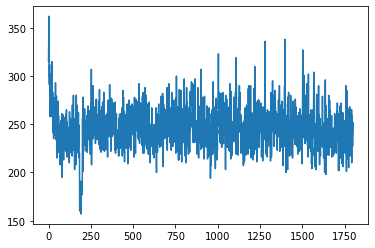

In [18]:
file_ids=[['17','control']]  
    
data_processor=Pyfish(file_ids[0])
data_processor.drop_faulty_frames()

In [3]:
file_ids=[['17','control']]  
    


    
#data_processor=Pyfish(file_ids[0])
#data_processor.andreas_registration()

In [4]:
#file_ids=[['04','amph'],['2','control']]  
file_ids=[['43','amph'],['41','amph'],['9','control']]  

for j in file_ids:
    data_processor=Pyfish(j)
    data_processor.andreas_registration()

Number of timepoints:  1800
working on plane:  0
working on plane:  1
working on plane:  2
working on plane:  3
working on plane:  4
working on plane:  5
working on plane:  6
working on plane:  7
working on plane:  8
working on plane:  9
working on plane:  10
working on plane:  11
working on plane:  12
working on plane:  13
working on plane:  14
working on plane:  15
working on plane:  16
working on plane:  17
working on plane:  18
working on plane:  19
working on plane:  20
time taken: 11264.071668624878
Number of timepoints:  1800
working on plane:  0
working on plane:  1
working on plane:  2
working on plane:  3
working on plane:  4
working on plane:  5
working on plane:  6
working on plane:  7
working on plane:  8
working on plane:  9
working on plane:  10
working on plane:  11
working on plane:  12
working on plane:  13
working on plane:  14
working on plane:  15
working on plane:  16
working on plane:  17
working on plane:  18
working on plane:  19
working on plane:  20
time take

Loading raw data from a plane...
Time to load raw data file:  6.321382761001587
Loading raw data from a plane...0
Time to load raw data file:  6.21296763420105
Time taken to detrend:  92.46658372879028


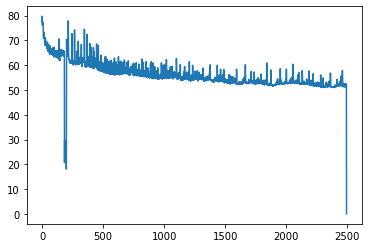

In [1]:
from scipy.signal import detrend
import matplotlib.pyplot as plt
import h5py
import time
import numpy as np
class Detrend():
    def __init__(self, filename, save_filename):
        self.filename=filename
        self.save_filename=save_filename
        self.initialization()
        
    def initialization(self):
        with h5py.File(filename, "r") as f:
            # List all groups
            print("Loading raw data from a plane...")
            start=time.time()
            dat=f['data'][:,0,:,:].astype('float32')
            end=time.time()
            print('Time to load raw data file: ',end-start)
            self.n_timepoints=dat.shape[0]
            
    def detrend_a_plane(self):
        with h5py.File(self.filename, "r") as f:
            print("Loading raw data from plane: "+str(self.plane_ind))
            start=time.time()
            dat=f['data'][:,self.plane_ind,:,:].astype('float32')
            end=time.time()
            print('Time to load raw data file: ',end-start)
        dat=dat.reshape(self.n_timepoints,1024*1024)
        start=time.time()
        detr=detrend(dat,axis=0)
        end=time.time()
        print('Time taken to detrend: ', end-start)
        plt.plot(np.mean(dat,axis=1))
        plt.show()
        return detr.reshape(self.n_timepoints,1024,1024)
    
    def detrend(self):
        detr_container = np.zeros((self.n_timepoints,1,1024,1024),dtype='float32')
        
        for z in range(0,1):
            self.plane_ind=z
            detr_container[:,z,:,:]= self.detrend_a_plane()
            
            
        detrended = h5py.File(self.save_filename, 'w')
        detrended.create_dataset('data',data=detr_container)
        detrended.close()

filename='C:/Users/koester_lab/Documents/Maria/masked/fish2_6dpf_medium_masked.h5'
save_filename='//ZMN-HIVE/User-Data/Maria/detrended/fish2_6dpf_medium_detrended.h5'

detr=Detrend(filename,save_filename)
detr.detrend()